## Loading of Dataset

In [72]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Libraries**

In [73]:
import pandas as pd
import numpy as np
from datetime import datetime

## Data Preprocessing
import re

## Testing scikit learn LDA
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# **TWITTER DATA IMPORT AND CLEANING**

In [74]:
## Import Data
tweets_data = pd.read_csv('/content/drive/My Drive/NUS Modules/Ryan 4222/tweets.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (16,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
## Filter Relevant Columns
tweets = tweets_data[['created_at', 'text', 'retweet_count', 'favorite_count']]

tweets.head()

,created_at,text,retweet_count,favorite_count
0,Tue Apr 12 01:29:47 +0000 2022,Nah @natfluential got outta there lmbo,0,3
1,Tue Apr 12 01:00:46 +0000 2022,. @natfluential I’m with you — there absolutel...,3,22
2,Tue Apr 12 00:41:12 +0000 2022,Folks: https://t.co/BvSPz5vv3U,0,2
3,Tue Apr 12 00:10:00 +0000 2022,X___X https://t.co/GUZnUGb85T,1,7
4,Tue Apr 12 00:08:09 +0000 2022,no doubt in my mind the aces are gonna have th...,8,53


In [76]:
tweets.describe()

,retweet_count,favorite_count
count,31118.000000,31118.000000
mean,378.307893,2982.134167
std,1510.896661,9386.115011
min,0.000000,0.000000
25%,8.000000,95.000000
50%,43.000000,431.000000
75%,250.000000,2315.000000
max,58647.000000,456823.000000


In [77]:
tweets['text'][3]

'X___X https://t.co/GUZnUGb85T'

## Data Pre Processing:

Retain:
1. Emotes
2. Capitals
3. Emoticons
4. Contractions
5. Punctuations
6. Stopwords

Remove:
1. Twitter usernames
2. '#' from Hashtag
3. Remove URLs(http:\, t.co)
4. Trailing white spaces

In [78]:
# Remove Twitter Handles
tweets['text'] = tweets['text'].str.replace(r'@[^\s]+ ','')
# Remove URLs
tweets['text'] = tweets['text'].str.replace(r'http\S+','')
tweets['text'] = tweets['text'].str.replace(r't.co\S+','')
# Strip # from hashtags
tweets['text'] = tweets['text'].str.replace('#', '')
# Trailing white spaces
tweets['text'] = tweets['text'].str.rstrip() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [79]:
## Further Cleaning of data

# Drop all NaNs
tweets = tweets.dropna()

# Convert relevant columns to numeric
pd.to_numeric(tweets['favorite_count'], downcast='integer')
pd.to_numeric(tweets['retweet_count'], downcast = 'integer')

## Convert Datetime to date
tweets['created_at'] = tweets['created_at'].apply(lambda d: datetime.strptime(d, '%a %b %d %H:%M:%S %z %Y').date())

2008-06-07


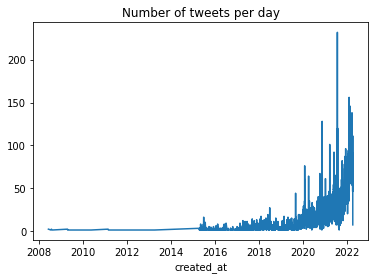

In [80]:
print(min(tweets['created_at']))
tweets.groupby('created_at').size().plot(title = "Number of tweets per day")

In [81]:
tweets.describe()

,retweet_count,favorite_count
count,31118.000000,31118.000000
mean,378.307893,2982.134167
std,1510.896661,9386.115011
min,0.000000,0.000000
25%,8.000000,95.000000
50%,43.000000,431.000000
75%,250.000000,2315.000000
max,58647.000000,456823.000000


In [82]:
tweets.head()

,created_at,text,retweet_count,favorite_count
0,2022-04-12,Nah got outta there lmbo,0,3
1,2022-04-12,. I’m with you — there absolutely needs to be ...,3,22
2,2022-04-12,Folks:,0,2
3,2022-04-12,X___X,1,7
4,2022-04-12,no doubt in my mind the aces are gonna have th...,8,53


In [83]:
## Filter all tweets from the 2021 season as we are focusing on 2122 season
start_2122_season_date = datetime(2021, 10, 19).date() # 20 October first game
last_2122_season_date= datetime(2021, 4, 6).date() # Last recorded tweet 06 April 2022

start_2021_season_date = datetime(2020, 12, 25).date() # 26 December 2020 first game
end_2021_season_date = datetime(2021, 5, 16).date() # 16 May 2021 Last Game

start_1920_season_date = datetime(2019, 10, 23).date() # 24 October 2019 first game
end_1920_season_date = datetime(2020, 8, 11).date() # 9 Aug 2020 Last Game before covid

start_1819_season_date = datetime(2018, 10, 17).date() # 17 October 2018 first game
end_1819_season_date = datetime(2019, 4, 9).date() # 9 Apr 2019 Last Game before covid

start_1718_season_date = datetime(2017, 10, 22).date() # 23 October 2017 first game
end_1718_season_date = datetime(2018, 4, 11).date() # 11 Apr 2018 Last Game before covid

# 24/10/2019
# 14/8/2020

## Filter by all dates more later than first game of 2021 season
temp_tweets_1 = tweets[tweets['created_at'] > start_1718_season_date]
## Filter for 2021 Season and 2122 Season tweets
season2021_2122_tweets = temp_tweets_1[(temp_tweets_1['created_at'] >= start_2122_season_date) | (temp_tweets_1['created_at'] <= end_2021_season_date) 
& (temp_tweets_1['created_at'] >= start_2021_season_date) | (temp_tweets_1['created_at'] <= end_1920_season_date) 
& (temp_tweets_1['created_at'] >= start_1920_season_date) | (temp_tweets_1['created_at'] <= end_1819_season_date) 
& (temp_tweets_1['created_at'] >= start_1819_season_date) | (temp_tweets_1['created_at'] <= end_1718_season_date)]

In [134]:
season2021_2122_tweets.head()

,created_at,text,retweet_count,favorite_count,vader_score,vader_compound,vader_sentiment,fav_rt_count
0,2022-04-12,Nah got outta there lmbo,0,3,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",-0.1027,NEGATIVE,3
1,2022-04-12,. I’m with you — there absolutely needs to be ...,3,22,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp...",0.2975,POSITIVE,25
2,2022-04-12,Folks:,0,2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL,2
3,2022-04-12,X___X,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL,8
4,2022-04-12,no doubt in my mind the aces are gonna have th...,8,53,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",-0.5719,NEGATIVE,61


In [86]:
print(min(season2021_2122_tweets['created_at']))

2017-10-23


## Exploratory Data Analysis

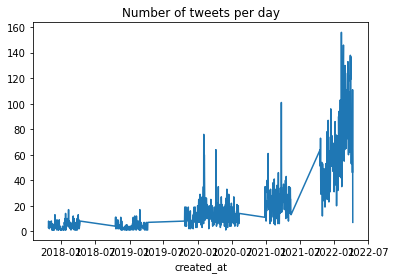

In [87]:
season2021_2122_tweets.groupby('created_at').size().plot(title = "Number of tweets per day")

More tweets as Season progresses

Text(0, 0.5, 'Favorite Count')

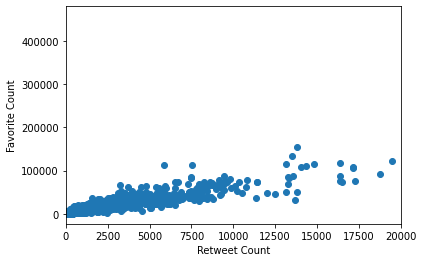

In [88]:
## Scatterplot
import matplotlib.pyplot as plt

plt.scatter(season2021_2122_tweets['retweet_count'], season2021_2122_tweets['favorite_count'])

# plt.ylim(0, 30000)
plt.xlim(0, 20000)
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')

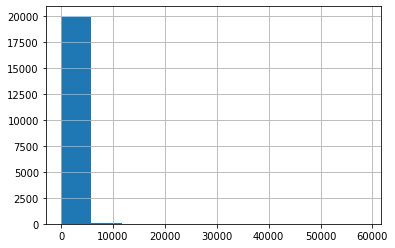

In [89]:
season2021_2122_tweets['retweet_count'].hist()



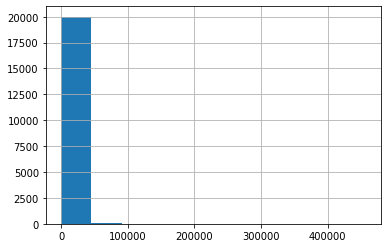

In [90]:
season2021_2122_tweets['favorite_count'].hist()

WordCloud

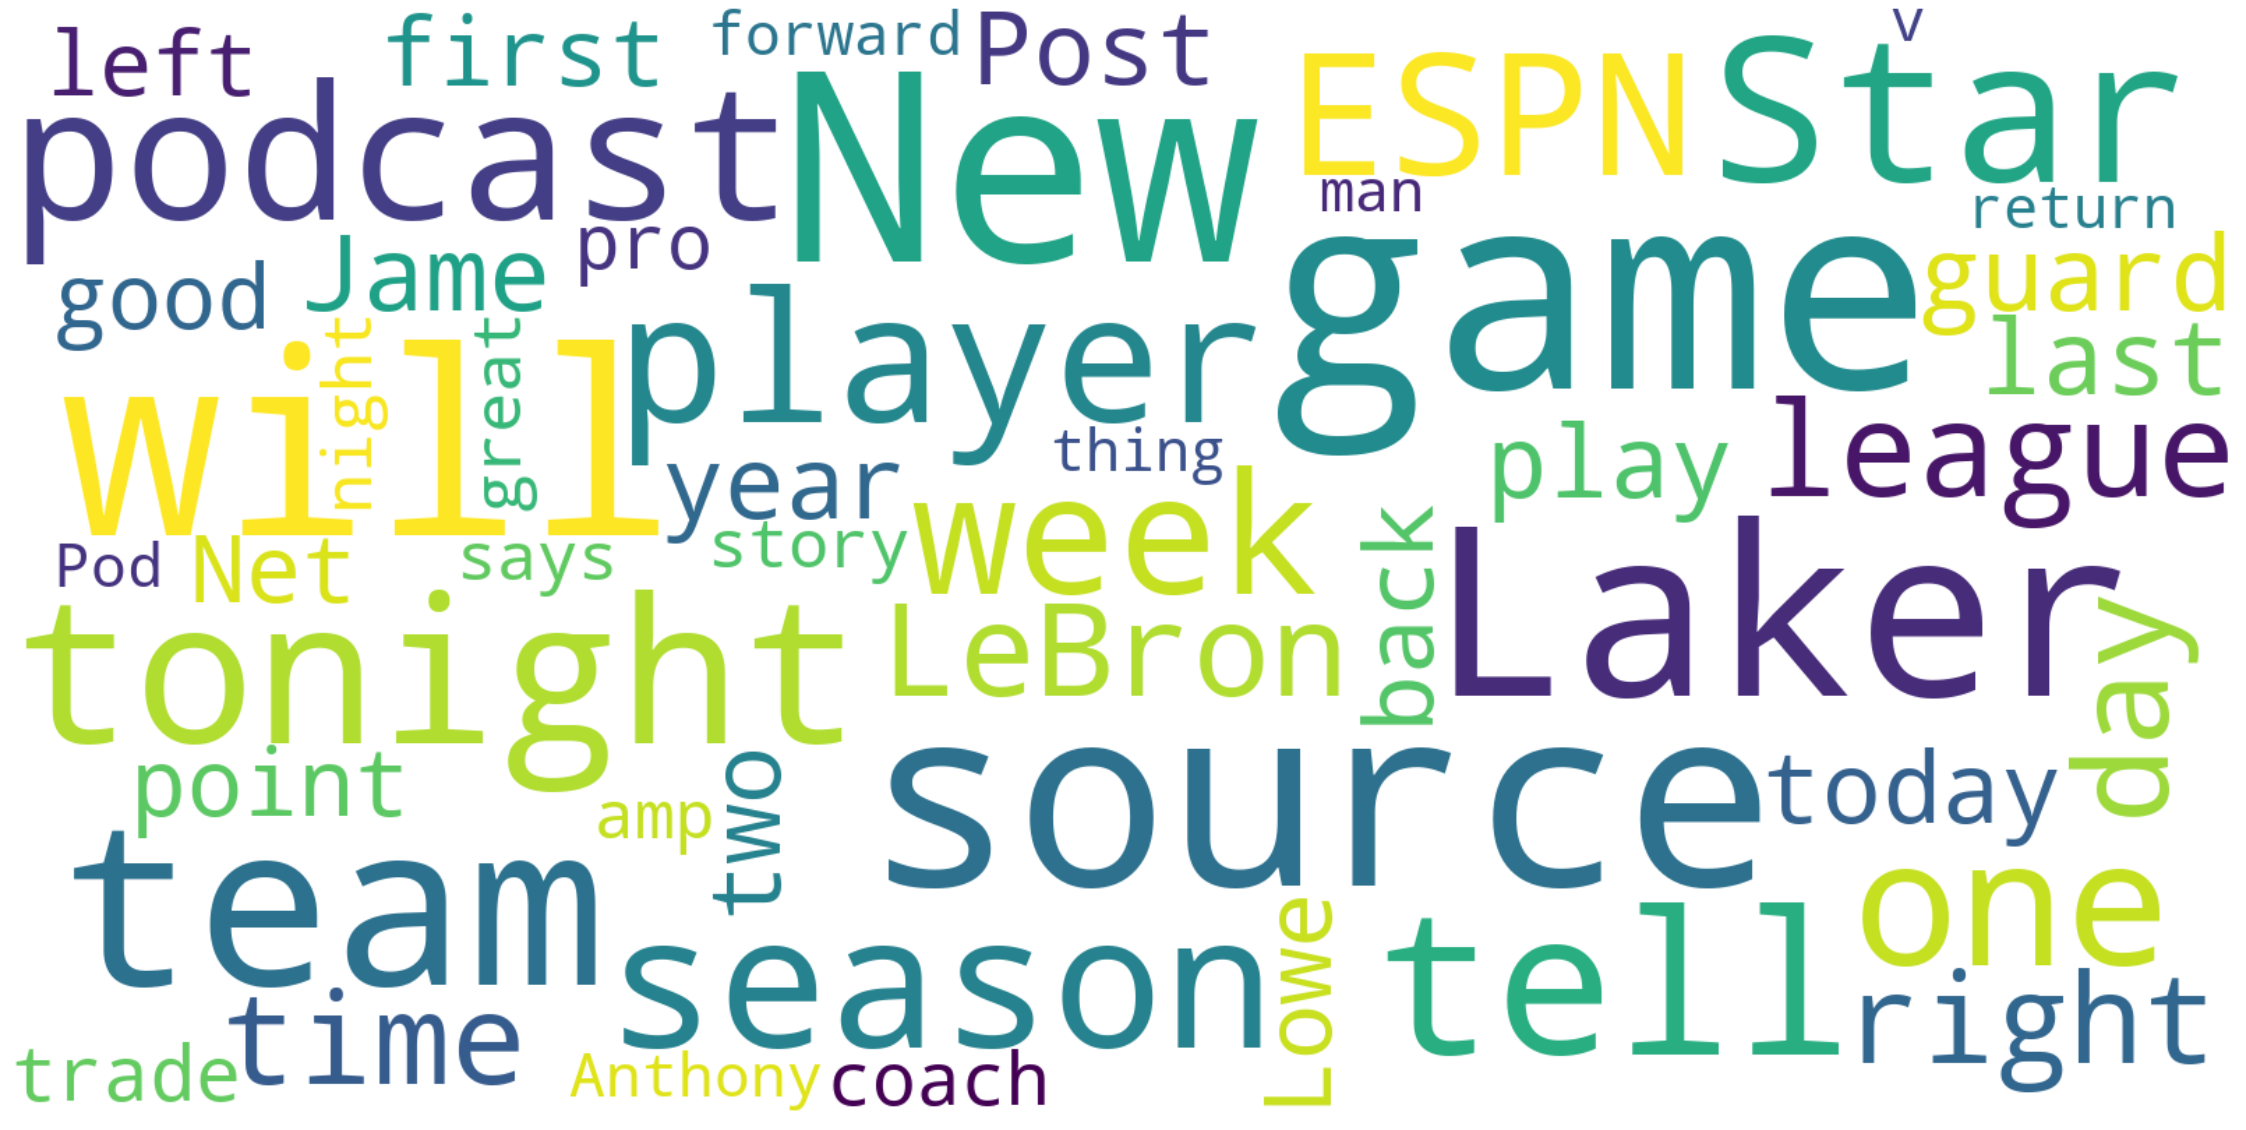

In [91]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## Obtain string of all sentence
string_of_words = season2021_2122_tweets['text'].str.cat(sep = ' ')

stopwords = set(STOPWORDS)
stopwords.update(['NBA', ' ESPN', 'say', 'now']) #adding our own stopwords

#Plot Word Cloud
wordcloud = WordCloud(width=1600, stopwords=stopwords,height=800,max_font_size=200,max_words=50,collocations=False, background_color='white').generate(string_of_words)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Engineering

## Vader Sentiment Analysis

In [92]:
## 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

season2021_2122_tweets['vader_score'] = season2021_2122_tweets['text'].apply(lambda text : sid.polarity_scores(text))

season2021_2122_tweets.head()

##
# Firstly, the context of the post will be ignored because Vader is a rule-based sentiment analysis approach that focuses on the individual words.
#  Secondly, it is unable to differentiate irony and sarcasm.
#   Thirdly, it is not trained to interpret Singlish.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,created_at,text,retweet_count,favorite_count,vader_score
0,2022-04-12,Nah got outta there lmbo,0,3,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp..."
1,2022-04-12,. I’m with you — there absolutely needs to be ...,3,22,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp..."
2,2022-04-12,Folks:,0,2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,2022-04-12,X___X,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,2022-04-12,no doubt in my mind the aces are gonna have th...,8,53,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp..."


VADER (Valence Aware Dictionary and sentiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

In [93]:
## Assigning the vader score to Positive, Neutral,Negative
season2021_2122_tweets['vader_compound'] = season2021_2122_tweets['vader_score'].apply(lambda score_dict: score_dict['compound'])
                                                                  
season2021_2122_tweets['vader_sentiment'] = ''
season2021_2122_tweets.loc[season2021_2122_tweets['vader_compound'] > 0, 'vader_sentiment' ] = 'POSITIVE'
season2021_2122_tweets.loc[season2021_2122_tweets['vader_compound'] == 0, 'vader_sentiment' ] = 'NEUTRAL'
season2021_2122_tweets.loc[season2021_2122_tweets['vader_compound'] < 0, 'vader_sentiment' ] = 'NEGATIVE'

season2021_2122_tweets.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,created_at,text,retweet_count,favorite_count,vader_score,vader_compound,vader_sentiment
0,2022-04-12,Nah got outta there lmbo,0,3,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",-0.1027,NEGATIVE
1,2022-04-12,. I’m with you — there absolutely needs to be ...,3,22,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp...",0.2975,POSITIVE
2,2022-04-12,Folks:,0,2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
3,2022-04-12,X___X,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
4,2022-04-12,no doubt in my mind the aces are gonna have th...,8,53,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",-0.5719,NEGATIVE


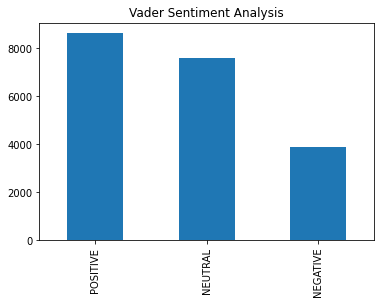

In [94]:
season2021_2122_tweets['vader_sentiment'].value_counts().plot(kind='bar', title = 'Vader Sentiment Analysis')

### Weighted Average of Vader Compound Score

As Favourite and Retweets represents how well received a tweet was, each tweet relevance can be measured by the amount of favourites and retweets it received. Therefore, we computed the weighted average of vader compound score for each day to obtain a more accurate score of the sentiments on that day.

We utilised the sum of retweet and favourite as the weights.

In [95]:
season2021_2122_tweets['fav_rt_count'] = season2021_2122_tweets[['retweet_count', 'favorite_count']].sum(axis=1)

tweets_vadercompound = season2021_2122_tweets.groupby('created_at').apply(lambda x: np.average(x.vader_compound, weights=x.fav_rt_count))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns"""
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [97]:
tweets_vadercompound = season2021_2122_tweets.groupby('created_at').apply(wavg, 'vader_compound', 'fav_rt_count')

In [98]:
tweets_vadercompound

created_at
2017-10-23   -0.015207
2017-10-24    0.674453
2017-10-25    0.554138
2017-10-26    0.567863
2017-10-27    0.636453
                ...   
2022-04-08    0.025946
2022-04-09    0.239600
2022-04-10    0.298906
2022-04-11    0.116651
2022-04-12   -0.182748
Length: 930, dtype: float64

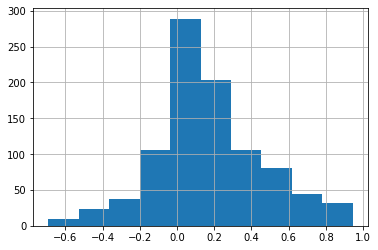

In [99]:
tweets_vadercompound.hist()

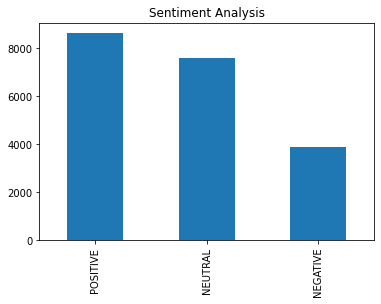

In [100]:
season2021_2122_tweets['vader_sentiment'].value_counts().plot(kind='bar', title = 'Sentiment Analysis')

In [101]:
season2021_2122_tweets.head()

,created_at,text,retweet_count,favorite_count,vader_score,vader_compound,vader_sentiment,fav_rt_count
0,2022-04-12,Nah got outta there lmbo,0,3,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",-0.1027,NEGATIVE,3
1,2022-04-12,. I’m with you — there absolutely needs to be ...,3,22,"{'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'comp...",0.2975,POSITIVE,25
2,2022-04-12,Folks:,0,2,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL,2
3,2022-04-12,X___X,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL,8
4,2022-04-12,no doubt in my mind the aces are gonna have th...,8,53,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",-0.5719,NEGATIVE,61


# Merging Tweets with Structured Data

In [102]:
nba_games_data = pd.read_excel('/content/drive/My Drive/NUS Modules/Ryan 4222/nba_games.xlsx', parse_dates=['Date'])


In [103]:
nba_games_data

,Opponent,Date,W/L,HRScore,OppScore
0,MIN,2021-10-20,L,106.0,124.0
1,OKC,2021-10-22,W,124.0,91.0
2,BOS,2021-10-24,L,97.0,107.0
3,DAL,2021-10-26,L,106.0,116.0
4,UTA,2021-10-28,L,91.0,122.0
...,...,...,...,...,...
383,WAS,2018-04-03,W,120.0,104.0
384,POR,2018-04-05,W,96.0,94.0
385,OKC,2018-04-07,L,102.0,108.0
386,LAL,2018-04-10,W,105.0,99.0


In [104]:
## Ensure that all of the dates are date objects in excel

## Convert all to datetime 
nba_games_data['Date'] = nba_games_data['Date'].apply(lambda x: x.date())

In [105]:
## Convert Weighted Average series to dictionary

tweets_vadercompound_dict = tweets_vadercompound.to_dict()

In [106]:
nba_games_data

,Opponent,Date,W/L,HRScore,OppScore
0,MIN,2021-10-20,L,106.0,124.0
1,OKC,2021-10-22,W,124.0,91.0
2,BOS,2021-10-24,L,97.0,107.0
3,DAL,2021-10-26,L,106.0,116.0
4,UTA,2021-10-28,L,91.0,122.0
...,...,...,...,...,...
383,WAS,2018-04-03,W,120.0,104.0
384,POR,2018-04-05,W,96.0,94.0
385,OKC,2018-04-07,L,102.0,108.0
386,LAL,2018-04-10,W,105.0,99.0


In [107]:
# print(tweets_vadercompound_dict.get(nba_games_data['Date'][0].date()))

In [108]:
# Map the weighted scores to the dates
nba_games_data['vader_compound'] = nba_games_data['Date'].map(tweets_vadercompound_dict)

In [109]:
nba_games_data

,Opponent,Date,W/L,HRScore,OppScore,vader_compound
0,MIN,2021-10-20,L,106.0,124.0,0.194570
1,OKC,2021-10-22,W,124.0,91.0,0.125540
2,BOS,2021-10-24,L,97.0,107.0,0.332980
3,DAL,2021-10-26,L,106.0,116.0,-0.060018
4,UTA,2021-10-28,L,91.0,122.0,0.094152
...,...,...,...,...,...,...
383,WAS,2018-04-03,W,120.0,104.0,-0.431836
384,POR,2018-04-05,W,96.0,94.0,0.041617
385,OKC,2018-04-07,L,102.0,108.0,0.615906
386,LAL,2018-04-10,W,105.0,99.0,0.475372


In [110]:
## Remove all games where there was no tweets data
nba_games_data = nba_games_data.dropna()

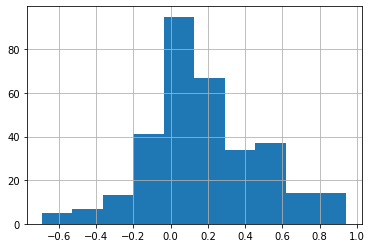

In [111]:
nba_games_data['vader_compound'].hist()

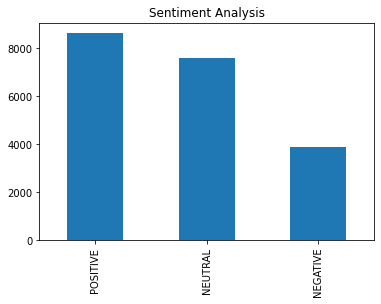

In [112]:
season2021_2122_tweets['vader_sentiment'].value_counts().plot(kind='bar', title = 'Sentiment Analysis')

In [113]:
nba_games_data.head()

,Opponent,Date,W/L,HRScore,OppScore,vader_compound
0,MIN,2021-10-20,L,106.0,124.0,0.194570
1,OKC,2021-10-22,W,124.0,91.0,0.125540
2,BOS,2021-10-24,L,97.0,107.0,0.332980
3,DAL,2021-10-26,L,106.0,116.0,-0.060018
4,UTA,2021-10-28,L,91.0,122.0,0.094152


In [114]:
nba_games_data.to_csv('nba_games_data_sentimentanalysis_weighted.csv')
nba_games_data.describe()


,HRScore,OppScore,vader_compound
count,327.000000,327.000000,327.000000
mean,112.626911,111.981651,0.177722
std,13.304882,12.870746,0.304010
min,80.000000,82.000000,-0.691374
25%,104.000000,103.000000,0.000000
50%,113.000000,112.000000,0.127659
75%,120.000000,121.000000,0.352411
max,159.000000,158.000000,0.944536


In [115]:
from google.colab import files

files.download('nba_games_data_sentimentanalysis_weighted.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Topic Modelling using Scikit-Learn LDA

For topic modelling, we shall be using all 31118 tweets from the tweets.csv file to identify the key topics mentioned by reporters. 

In [116]:
tweets

,created_at,text,retweet_count,favorite_count
0,2022-04-12,Nah got outta there lmbo,0,3
1,2022-04-12,. I’m with you — there absolutely needs to be ...,3,22
2,2022-04-12,Folks:,0,2
3,2022-04-12,X___X,1,7
4,2022-04-12,no doubt in my mind the aces are gonna have th...,8,53
...,...,...,...,...
31113,2021-11-17,I wonder if it's a coincidence that LMA checks...,1,15
31114,2021-11-17,"Unless your switching is locked the fuck in, d...",0,46
31115,2021-11-17,"Yeah, I'll take all the Warriors vs. Nets you ...",9,147
31116,2021-11-17,Great cut by Damian Lee to draw Bembry's atten...,0,5


In [117]:
data = tweets.text.values.tolist()

In [118]:
## Tokenization to remove unnecessary characters
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words_LDA = list(sent_to_words(data))

print(data_words_LDA[:1])

[['nah', 'got', 'outta', 'there', 'lmbo']]


In [119]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words_LDA, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

['get outta there', 'there absolutely need sort cutoff bubble year tea']


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

In [120]:
print(data_lemmatized[:2])

['get outta there', 'there absolutely need sort cutoff bubble year tea']


In [121]:
## Vectorize Data
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [122]:
## Check Sparcity
# Materialize the sparse data
data_dense = data_vectorized.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.2362391797017822 %


In [123]:
## Building Model

lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words. This can be captured using topic coherence measure, an example of this is described in the gensim tutorial I mentioned earlier.

In [124]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1093590.3795257765
Perplexity:  1221.1068681830895
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


GridSearch Best Model

In [125]:
# Define Search Param

##10, 15, 20, 25, 30 
search_params = {'n_components': [5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15, 20, 25]})

View Best Model

In [126]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -227613.54103246244
Model Perplexity:  830.4896504122854


Compare LDA Model Performance

Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.

This makes me think, even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘alt.atheism’ and ‘soc.religion.christian’ can have a lot of common words. Same with ‘rec.motorcycles’ and ‘rec.autos’, ‘comp.sys.ibm.pc.hardware’ and ‘comp.sys.mac.hardware’, you get the idea.

To tune this even further, you can do a finer grid search for number of topics between 10 and 15. But I am going to skip that for now.

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. I don’t know that yet. But LDA says so. Let’s see.

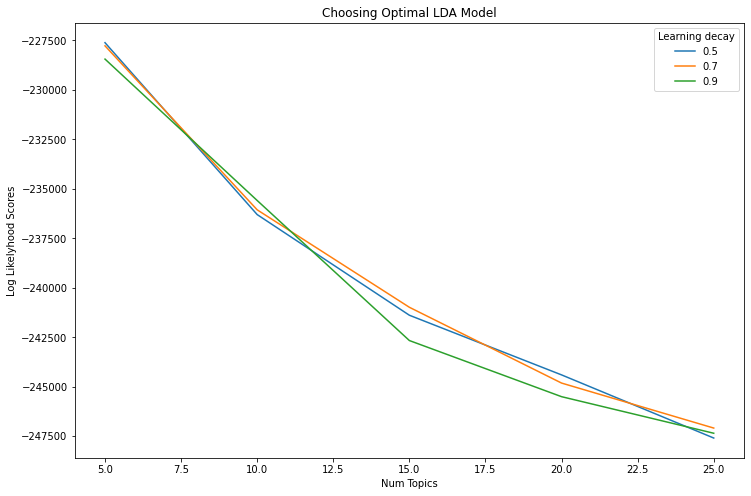

In [127]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5,10,15,20,25]

log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]
# log_likelyhoods_5 = [round(gscore['mean_test_score'][index]) for index in range(len(gscore['params'])) if gscore['params'][index]['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore['mean_test_score'][index]) for index in range(len(gscore['params'])) if gscore['params'][index]['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore['mean_test_score'][index]) for index in range(len(gscore['params'])) if gscore['params'][index]['learning_decay']==0.9]

# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

see which topic has the highest contribution to that document and assign it.

In [128]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.200000,0.200000,0.200000,0.200000,0.200000,0
Doc1,0.030000,0.030000,0.030000,0.190000,0.720000,4
Doc2,0.100000,0.100000,0.600000,0.100000,0.100000,2
Doc3,0.200000,0.200000,0.200000,0.200000,0.200000,0
Doc4,0.030000,0.200000,0.590000,0.150000,0.030000,2
Doc5,0.280000,0.030000,0.490000,0.170000,0.030000,2
Doc6,0.480000,0.040000,0.040000,0.040000,0.390000,0
Doc7,0.200000,0.200000,0.200000,0.200000,0.200000,0
Doc8,0.220000,0.230000,0.490000,0.030000,0.030000,2
Doc9,0.070000,0.070000,0.070000,0.400000,0.390000,3


In [129]:
## Review topics distribution across documents

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,9091
1,2,6483
2,4,6220
3,1,5276
4,3,4048


In [130]:
lda_output

array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.02869021, 0.0287853 , 0.02916832, 0.18938897, 0.72396722],
       [0.1001089 , 0.1000004 , 0.59812624, 0.10000045, 0.10176402],
       ...,
       [0.06694791, 0.7313734 , 0.06736172, 0.06735073, 0.06696624],
       [0.02273494, 0.17408638, 0.0228637 , 0.02225403, 0.75806095],
       [0.0679941 , 0.06712089, 0.73155033, 0.06666738, 0.06666729]])

In [131]:
## Visualize LDA Model

pyLDAvis.enable_notebook()



panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  22.065103
2       51.163364 -159.968018       2        1  20.660443
4      -73.144554   21.523815       3        1  20.087523
1      -66.410133 -110.606438       4        1  19.541569
3       54.417324   12.443444       5        1  17.645363, topic_info=        Term         Freq        Total Category  logprob  loglift
752     game  2735.000000  2735.000000  Default  30.0000  30.0000
1690  source  2610.000000  2610.000000  Default  29.0000  29.0000
2047    year  1418.000000  1418.000000  Default  28.0000  28.0000
1161     new  1442.000000  1442.000000  Default  27.0000  27.0000
1828    tell  1772.000000  1772.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
1114    miss   248.752064   515.526428   Topic5  -4.6927   1.0060
1509  return   268.037051   646.564241   Topic5  -4.6180   0.8541
1286    plan   219.432499   410.304972   Topic5  -4.8181   1.1088
1291  player   221.728620  1403.945312   Topic5  -4.8077  -0.1109
965    laker   190.348723  1357.302898   Topic5  -4.9603  -0.2297

[329 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
17        4  0.994287   acquire
24        2  0.997069  actually
42        3  0.010976    agency
42        5  0.987814    agency
43        5  0.997069     agent
...     ...       ...       ...
2044      2  0.988800     wrong
2047      1  0.002116      year
2047      2  0.020450      year
2047      3  0.001410      year
2047      5  0.976662      year

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

In [132]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abdominal,ability,able,abou,absence,absolute,absolutely,accept,access,accident,...,writer,wrong,yahoosport,yard,year,yell,yesterday,young,youtube,zone
Topic0,0.200386,7.171918,58.013893,4.234147,6.115342,12.077163,40.175931,0.368157,0.201756,0.201069,...,0.204631,0.201876,0.200131,0.201739,2.679007,0.200590,43.844703,114.936359,6.326411,0.201551
Topic1,0.200060,5.148020,36.674348,1.734757,10.949599,0.200414,0.200855,25.933049,9.111957,0.202794,...,0.200388,0.200298,21.070822,0.200512,0.202997,0.200079,0.212135,0.203459,0.200963,0.200537
Topic2,0.200136,0.454857,0.203618,6.165815,0.202286,21.318035,27.323950,0.202513,0.202352,0.200010,...,0.804865,92.194658,0.200043,0.200558,29.236528,0.201757,89.219613,47.809903,0.205736,0.200768
Topic3,14.199414,0.202715,2.752300,0.201908,13.429464,0.201965,0.782430,0.202664,0.200557,0.202239,...,0.200180,0.200806,16.328917,0.201106,1352.188357,0.200081,5.178079,19.120032,0.200755,0.200567
Topic4,0.200005,25.022490,0.355840,2.663373,6.303309,0.202424,48.516833,6.293617,2.283378,10.193888,...,21.589936,0.202362,0.200087,26.196084,1.693112,19.197494,37.545470,56.930246,9.066134,24.196577


In [133]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,game,time,good,win,play,tonight,great,laker,point,man,friend,night,final,say,congratulation
Topic 2,source,team,player,tell,trade,say,espn,play,pro,coach,tonight,league,today,return,health
Topic 3,new,podcast,week,start,thank,story,today,want,talk,team,just,post,fan,amp,work
Topic 4,year,source,tell,say,deal,right,sign,day,free,contract,agree,season,espn,leave,agent
Topic 5,just,season,look,make,come,think,good,point,podcast,laker,shoot,great,run,big,love
